In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import signac
import gsd
import freud
from scipy.stats import uniform
from scipy.optimize import curve_fit
from scipy.special import erf
from joblib import Parallel, delayed

import pandas as pd

In [3]:
#Extracting information

poses = []
boxes = []
        
f = open("spce_278.dump")
text = f.readlines()

num_atoms = int(np.fromstring(text[3][:-1], sep=' ')[0])
num_frames = int(len(text) / (9 + num_atoms))


for i in range(0, num_frames, 1):
        it = 9 + (9+num_atoms)*i
        et = it + num_atoms
        box0 = np.fromstring(text[it-4][:13], sep=' ')*-20
        box1 = np.fromstring(text[it-3][:13], sep=' ')*-20

        boxes.append([box0, box1, box1])
        #print(box0)
        print(i,it, et)
        pos = []

        for j in range(it, et):
            pos.append(np.fromstring(text[j][:-1], sep=' '))

        poses.append(np.asarray(pos))                


        #break




f.close()





print('done')

0 9 5193
1 5202 10386
2 10395 15579
3 15588 20772
4 20781 25965
5 25974 31158
6 31167 36351
7 36360 41544
8 41553 46737
9 46746 51930
10 51939 57123
11 57132 62316
12 62325 67509
13 67518 72702
14 72711 77895
15 77904 83088
16 83097 88281
17 88290 93474
18 93483 98667
19 98676 103860
20 103869 109053
21 109062 114246
22 114255 119439
23 119448 124632
24 124641 129825
25 129834 135018
26 135027 140211
27 140220 145404
28 145413 150597
29 150606 155790
30 155799 160983
31 160992 166176
32 166185 171369
33 171378 176562
34 176571 181755
35 181764 186948
36 186957 192141
37 192150 197334
38 197343 202527
39 202536 207720
40 207729 212913
41 212922 218106
42 218115 223299
43 223308 228492
44 228501 233685
45 233694 238878
46 238887 244071
47 244080 249264
48 249273 254457
49 254466 259650
50 259659 264843
51 264852 270036
52 270045 275229
53 275238 280422
54 280431 285615
55 285624 290808
56 290817 296001
57 296010 301194
58 301203 306387
59 306396 311580
60 311589 316773
61 316782 321966
6

In [15]:


# Computing fields ignoring the fact that they are Gaussian Charges

projE = []

for i in range(50, len(poses), 20): #Ignoring the first 50 frames, only analyzing every 20 frames


    fbox = freud.box.Box.from_box(boxes[i])


    pos = poses[i]
    Opos = pos[:,2:][pos[:,0] == 1]
    Hpos = pos[:,2:][pos[:,0] == 2]
    
    # Getting O to H vectors    
    vHpos = np.reshape(Hpos, [int(len(Hpos)/2), 2, 3])
    omat = np.copy(vHpos)
    fbox = freud.box.Box.from_box(boxes[i])
    omat[:,0] = fbox.wrap(vHpos[:,0,:] - Opos)
    omat[:,1] = fbox.wrap(vHpos[:,1] - Opos)
    omat = np.reshape(omat, [len(Hpos), 3])


    fields = []

    Hdel_list = (np.arange(0, len(Hpos))/2).astype('int')
    Odel_list = (np.arange(0, len(Opos))).astype('int')

    for j in range(0,len(Hpos)): # Need these to ignore intramolecular E-fields

        Hpoint = Hpos[j]
        tHpos = Hpos[Hdel_list != int(j/2)]
        tOpos = Opos[Odel_list != int(j/2)]
        dpos = fbox.wrap(Hpoint - tHpos)
        dis = np.linalg.norm(dpos, axis=1)
        dpos = dpos[dis > 1e-2]
        dis = dis[dis > 1e-2]
        direct = (dpos.T / dis).T

        Hfields = (direct.T / dis**2).T

        dpos = fbox.wrap(Hpoint - tOpos)
        dis = np.linalg.norm(dpos, axis=1)
        dpos = dpos[dis > 1e-2]
        dis = dis[dis >1e-2]
        direct = (dpos.T / dis).T

        Ofields = (direct.T / dis**2).T


        field = 0.4238*np.sum(Hfields, axis=0) -0.8476*np.sum(Ofields, axis=0)

        fields.append(field)


        #print(j)


    projE.append(np.sum(omat*fields, axis=1))
    
    print(i)


            
projE = np.array(projE)

50
70
90
110
130
150
170
190


Text(0.5, 0, 'Field Strength (V/A)')

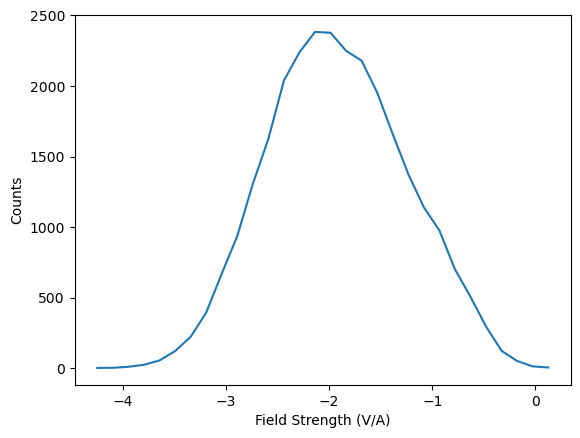

In [14]:


heights, bins = np.histogram(-14.4*projE, 30) # -14.4 is for conversion

binw = bins[1] - bins[0]
bin_centers = bins[:-1] + binw/2


plt.plot(bin_centers, heights)

plt.ylabel("Counts")
plt.xlabel("Field Strength (V/A)")

100
200
300
400
